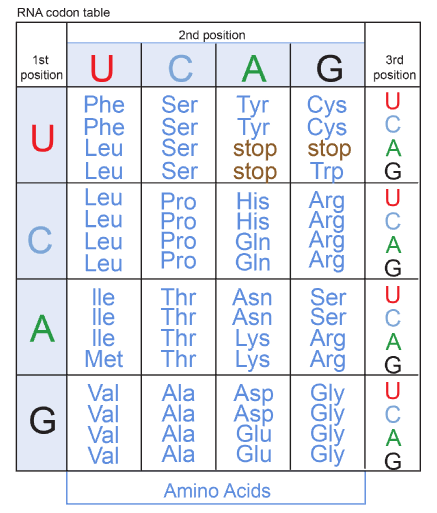

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sys.path.append('../scripts/')
import utils

In [3]:
# SUBSTITUTIONS_PATH = '../data/overall_mutations_with_context2.csv'  # 0-based
GISAID_ANNOT_PATH = '../data/gisaid_mutations_annotation.csv' # 0-based
GENOME_ANNOT_PATH = '../data/gemone_structures_annot_with_UTRs.csv'  # 1-based
REF_ANNOT = '../data/ref_annot.csv'  # 0-based

### Read tables

- filter gisaid substitutions from deletions and not-terminal nodes
- make genome_annot `Pos` 0-based

In [4]:
substitutions = pd.read_csv(GISAID_ANNOT_PATH)
substitutions = substitutions[
    (substitutions.parent_nucl != '-') & 
    (substitutions.child_nucl != '-') &
    (~ substitutions.child_node.str.startswith('#'))
]
substitutions['Pos'] = substitutions.pos
substitutions['Mut'] = substitutions.parent_nucl + ">" + substitutions.child_nucl


genome_annot = pd.read_csv(GENOME_ANNOT_PATH)
ref_annot = pd.read_csv(REF_ANNOT)
genome_annot['Pos'] -= 1  # to 0-based

assert ref_annot.shape[0] == genome_annot.shape[0]

In [5]:
print('#SNPs on terminal nodes')
print(substitutions.shape)

#SNPs on terminal nodes
(374695, 14)


In [6]:
substitutions.head(10000).tail()

,pos,parent_nucl,child_nucl,parent_node,child_node,GenName,GenType,CodonNumber,child_codon,parent_codon,child_aa,parent_aa,Pos,Mut
16880,17675,C,T,#41595#,hCoV-19/Italy/LOM-UniMI07/2020|EPI_ISL_779709|...,ORF1ab,translated,5805.0,ATT,ATC,I,I,17675,C>T
16882,17675,C,T,#22479#,hCoV-19/Sweden/20-23683/2020|EPI_ISL_661280|20...,ORF1ab,translated,5805.0,ATT,ATC,I,I,17675,C>T
16889,17675,C,T,#16661#,hCoV-19/Denmark/DCGC-13841/2020|EPI_ISL_713055...,ORF1ab,translated,5805.0,ATT,ATC,I,I,17675,C>T
16890,17675,T,C,#35157#,hCoV-19/Uganda/UG106/2020|EPI_ISL_738013|2020-...,ORF1ab,translated,5805.0,ATC,ATT,I,I,17675,T>C
16894,17675,T,C,#50499#,hCoV-19/Germany/HH-hpi-p1760/2020|EPI_ISL_7761...,ORF1ab,translated,5805.0,ATC,ATT,I,I,17675,T>C


### Tables to be merged:

In [7]:
substitutions[['Pos', 'Mut', 'GenName', 'GenType', 
               'child_codon', 'parent_codon', 'parent_nucl', 
               'child_nucl', 'child_aa', 'parent_aa']] .head(2)

,Pos,Mut,GenName,GenType,child_codon,parent_codon,parent_nucl,child_nucl,child_aa,parent_aa
5,240,T>C,5UTR,untranslated,NaN,NaN,T,C,NaN,NaN
6,240,T>C,5UTR,untranslated,NaN,NaN,T,C,NaN,NaN


In [8]:
genome_annot[['Pos', 'RefNuc', 'IsStem']] .head(2)

,Pos,RefNuc,IsStem
0,0,A,0.0
1,1,T,0.0


In [9]:
ref_annot[['Pos', 'NucInCodon']] .head(2)

,Pos,NucInCodon
0,0,None
1,1,None


------------
### Merging

In [10]:
gisaid = pd.merge(
    pd.merge(
        substitutions[['Pos', 'Mut', 'GenName', 'GenType', 'child_node', 'parent_codon', 
                       'child_codon', 'parent_nucl', 'child_nucl', 'parent_aa', 'child_aa']],
        genome_annot[['Pos', 'RefNuc', 'IsStem']],
        on='Pos'
    ),
    ref_annot[['Pos', 'NucInCodon']],
    on='Pos'
)
print(gisaid.shape)
gisaid.head(2)

(374695, 14)


,Pos,Mut,GenName,GenType,child_node,parent_codon,child_codon,parent_nucl,child_nucl,parent_aa,child_aa,RefNuc,IsStem,NucInCodon
0,240,T>C,5UTR,untranslated,hCoV-19/USA/CT-CDC-2-3693464/2020|EPI_ISL_7471...,NaN,NaN,T,C,NaN,NaN,C,0.0,None
1,240,T>C,5UTR,untranslated,hCoV-19/USA/CA-CHLA-PLM28873007/2020|EPI_ISL_7...,NaN,NaN,T,C,NaN,NaN,C,0.0,None


### Use only 4-fold

In [91]:
ffcodon_starts = ['TC', 'CT', 'CC', 'CG', 'AC', 'GT', 'GC', 'GG']

# true 4-fold
gisaid = gisaid[
    (gisaid.GenType == 'translated') & 
    (gisaid.NucInCodon == '3') & 
    (gisaid.parent_nucl == gisaid.RefNuc) &
    (gisaid.child_aa == gisaid.parent_aa)
]
print(gisaid.shape)
gisaid = gisaid[gisaid.child_codon.apply(lambda codon: codon[:2] in ffcodon_starts)]

# gisaid.to_csv('../data/gisaid_terminal_4-fold.csv', index=None)
gisaid.shape

(33179, 14)


(33179, 14)

In [92]:
gisaid.head()

,Pos,Mut,GenName,GenType,child_node,parent_codon,child_codon,parent_nucl,child_nucl,parent_aa,child_aa,RefNuc,IsStem,NucInCodon
289,11172,C>A,ORF1ab,translated,hCoV-19/USA/CT-CDC-2-3693464/2020|EPI_ISL_7471...,CTC,CTA,C,A,L,L,C,NaN,3
290,11172,C>T,ORF1ab,translated,hCoV-19/USA/FL-BPHL-0767/2020|EPI_ISL_512572|2...,CTC,CTT,C,T,L,L,C,NaN,3
293,11172,C>T,ORF1ab,translated,hCoV-19/USA/TX-HMH-MCoV-10441/2020|EPI_ISL_789...,CTC,CTT,C,T,L,L,C,NaN,3
294,11172,C>T,ORF1ab,translated,hCoV-19/USA/WI-GMF-09171/2020|EPI_ISL_489942|2...,CTC,CTT,C,T,L,L,C,NaN,3
298,11172,C>A,ORF1ab,translated,hCoV-19/USA/NY-NYCPHL-001556/2020|EPI_ISL_7454...,CTC,CTA,C,A,L,L,C,NaN,3


In [93]:
gisaid[gisaid.IsStem == 1].shape, gisaid[gisaid.IsStem == 0].shape

((4026, 14), (2795, 14))

In [94]:
pre_mutspec_free = gisaid[gisaid.IsStem == 0].groupby('Mut').RefNuc.count()  
pre_mutspec_free.name = 'Count'

pre_mutspec_stem = gisaid[gisaid.IsStem == 1].groupby('Mut').RefNuc.count()  
pre_mutspec_stem.name = 'Count'

In [95]:
my_ann = pd.merge(ref_annot, genome_annot[['Pos', 'IsStem']], on='Pos')

my_ann[(my_ann.NucInCodon == '3') & (my_ann.IsStem == 0)].RefNuc.value_counts()

T    271
A    206
C     60
G     41
Name: RefNuc, dtype: int64

In [96]:
nucl_shares_free = my_ann[(my_ann.NucInCodon == '3') & (my_ann.IsStem == 0)].RefNuc.value_counts()
nucl_shares_free /= nucl_shares_free.min()

Exp_free = np.array([[nucl_shares_free[x]]*3 for x in 'ACGT']).flatten()

nucl_shares_free

T    6.609756
A    5.024390
C    1.463415
G    1.000000
Name: RefNuc, dtype: float64

In [97]:
pre_mutspec_free /= Exp_free
pre_mutspec_free

Mut
A>C      3.781553
A>G     47.966019
A>T     21.893204
C>A     19.816667
C>G     18.450000
C>T    818.633333
G>A     61.000000
G>C      9.000000
G>T    455.000000
T>A      8.774908
T>C     75.797048
T>G     13.162362
Name: Count, dtype: float64

In [98]:
nucl_shares_stem = my_ann[(my_ann.NucInCodon == '3') & (my_ann.IsStem == 1)].RefNuc.value_counts()
nucl_shares_stem /= nucl_shares_stem.min()
Exp_stem = np.array([[nucl_shares_stem[x]]*3 for x in 'ACGT']).flatten()

nucl_shares_stem

T    2.493274
A    1.394619
C    1.143498
G    1.000000
Name: RefNuc, dtype: float64

In [99]:
pre_mutspec_stem /= Exp_stem
pre_mutspec_stem

Mut
A>C      22.945338
A>G     259.569132
A>T      71.704180
C>A      86.576471
C>G       6.121569
C>T    1191.956863
G>A     257.000000
G>C      48.000000
G>T     853.000000
T>A      66.980216
T>C     273.937050
T>G      22.059353
Name: Count, dtype: float64

In [100]:
print('Мутспеки отличаются')
scipy.stats.chisquare(pre_mutspec_stem, pre_mutspec_free)

Мутспеки отличаются


Power_divergenceResult(statistic=3604.2924994095715, pvalue=0.0)

In [101]:
mutations = pre_mutspec_free.index
# mutations = ['G>T']

for mut in mutations:
    n_C2T_free = pre_mutspec_free[mut]
    n_X2X_free = pre_mutspec_free.drop(mut).sum()

    n_C2T_stem = pre_mutspec_stem[mut]
    n_X2X_stem = pre_mutspec_stem.drop(mut).sum()

    for_ftest = np.array([[n_C2T_free, n_C2T_stem],
                          [n_X2X_free, n_X2X_stem]])
    
    _, pval = scipy.stats.fisher_exact(for_ftest)

    print(mut, pval)

A>C 0.030670666339173952
A>G 9.410602955176185e-13
A>T 0.04314143530003259
C>A 0.0007346627982510025
C>G 2.8695579327703257e-05
C>T 2.0272136747229999e-22
G>A 2.1325680117458392e-08
G>C 0.004384539546603231
G>T 0.1038495839218777
T>A 1.4893845798924962e-05
T>C 1.4263169889822368e-06
T>G 0.5918850292423947


In [89]:
for_ftest

array([[  13.16236162,   22.05935252],
       [1540.11273242, 3137.79081767]])

Table for Fisher test

|     | unpaired | paired |
|-----|-----|------|
|#C>T | 2977|  3022|
|#other 11|   2466|   4218|


## Ниже метод Степана - с использованием не мутирующих
Работает "хуже", если правильно

In [80]:
_d = ref_annot[ref_annot.GenType == 'translated']
ff_positions = _d[
    (_d.NucInCodon == '3') &
    (_d.RefCodon.apply(lambda codon: codon[:2] in ffcodon_starts)) 
]
ff_positions = pd.merge(ff_positions, genome_annot[['Pos', 'IsStem']], on='Pos')
ff_positions.head()

,Pos,RefNuc,GenName,GenType,CodonNumber,RefCodon,RefAa,NucInCodon,IsStem
0,276,T,ORF1ab,translated,4.0,CTT,L,3,1.0
1,279,C,ORF1ab,translated,5.0,GTC,V,3,0.0
2,282,T,ORF1ab,translated,6.0,CCT,P,3,1.0
3,285,T,ORF1ab,translated,7.0,GGT,G,3,0.0
4,300,A,ORF1ab,translated,12.0,ACA,T,3,NaN


In [81]:
ff_positions[ff_positions.IsStem == 1].RefNuc.value_counts()

T    307
A    170
C    110
G     57
Name: RefNuc, dtype: int64

In [82]:
ff_positions[ff_positions.IsStem == 0].RefNuc.value_counts()

T    136
A     81
C     24
G     12
Name: RefNuc, dtype: int64

In [83]:
gisaid.child_node.nunique()

22229

In [84]:
n_nucl_stem = ff_positions[ff_positions.IsStem == 1].RefNuc.value_counts() * gisaid.child_node.nunique()
n_nucl_free = ff_positions[ff_positions.IsStem == 0].RefNuc.value_counts() * gisaid.child_node.nunique()

In [85]:
mutations = pre_mutspec_free.index
# mutations = ['G>T']

for mut in mutations:
    first_nucl = mut[0]
    for_test = [
        [pre_mutspec_free[mut], pre_mutspec_stem[mut]],
        [
            n_nucl_free[first_nucl] - pre_mutspec_free[mut], 
            n_nucl_stem[first_nucl] - pre_mutspec_stem[mut]
        ]
    ]
    _, pval = scipy.stats.fisher_exact(for_test)
    print(mut, pval)

A>C 0.03150150103705322
A>G 2.2148886474898438e-11
A>T 0.05769054947682224
C>A 0.8993547659592367
C>G 1.588930902200723e-09
C>T 1.1624306372931342e-125
G>A 0.41541453044370524
G>C 0.8623254612388909
G>T 1.783646624607429e-51
T>A 7.44383014267846e-05
T>C 0.00015262980485504935
T>G 0.4635315640868662


In [90]:
for_test

[[13.162361623616237, 22.059352517985612],
 [3023130.8376383763, 6824280.940647482]]